# Convolutional NN on [MNIST](https://github.com/pytorch/examples/tree/master/mnist) with [torch](https://pytorch.org/)
stough 202-

Following a simple digit classification on MNIST, using a small convolutional neural network (CNN).

A [convolutional layer](https://pytorch.org/docs/stable/nn.html#conv2d) solves for simple spatial filtering
operations where the output (feature map) contains useful information for the downstream or deeper layers 
in the network. With $in\_channels$ input channels, $out\_channels$ output feature maps, and $kernel\_size$ for the filtering, the layer will have $in\_channels * out\_channels * kernel\_size^2 + out\_channels$ parameters 
to optimize. 

In [1]:
%matplotlib inline
# or widget
import matplotlib.pyplot as plt

import numpy as np
from random import shuffle
import copy
import tempfile

# from keras.datasets import mnist
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

# torch
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torch.nn.functional as F

from torch import nn
from torch.autograd import Variable
from torch.nn import Module

from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

# For timing.
import time
tic, toc = (time.time, time.time)

## Define the Network
A more complicated network, using Convolutional Layers to transform the original image
into a collection of features that a linear layer can use to discriminate 
among the classes/digits.

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # padding is 0 by default, so 
                                            # we lose a pixel on each side.
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x) # input: 1x28x28, output: 32x26x26
        x = F.relu(x)
        x = self.conv2(x) # input: 32x26x26, output: 64x24x24
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # input: 64x24x24, output: 64x12x12
        x = self.dropout1(x) # randomly zero out some of the features. (in training only)
        x = torch.flatten(x, 1) # flatten the 64x12x12 to a single dimension (9216) 
        x = self.fc1(x) 
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
#         output = torch.sigmoid(x)
        return output

## Training and Test functions.
During training, the optimizer modifies the parameters of the model in a way that minimizes the loss
function. See more detail [here](https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step), but a lot is hidden from you. Just viewing it pythonically for example, it is not clear how the loss
and the optimizer are connected.

In [3]:
def train(args, model, device, train_loader, optimizer, epoch):
    starttime = tic()
    model.train()
    loss_sum = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        # loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        loss_sum += loss.item()
    
    loss_avg = loss_sum/len(train_loader.dataset)
    
    endtime = toc()
    print('\nTrain set: Average loss: {:.4f} ({:.3f} sec)'.\
          format(loss_avg, 
                 endtime-starttime))
    
    return loss_avg


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            # test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_acc))
    
    return test_loss, test_acc

## Namespace to replace the argparse business

In [4]:
from argparse import Namespace
# What is a Namespace? It looks like this. 
# Such objects allow you to use the dot operator, like a struct in C.
# class Namespace:
#     def __init__(self, **kwargs):
#         self.__dict__.update(kwargs)

args = Namespace(
    no_cuda=False, 
    seed=1, 
    batch_size=64,
    test_batch_size=1000,
    epochs=10,
    lr=1e-3,
    gamma=0.4,
    log_interval=250,
    save_model=False
)

## Organize the MNIST data
We'll use the [torchvision transforms](https://pytorch.org/docs/stable/torchvision/transforms.html#) to 
modify the dataset without having to convert to numpy arrays ourselves. If organized correctly, we won't
need our own Dataset class and collate function.

In [5]:
# Thank you: https://www.aiworkbox.com/lessons/load-mnist-dataset-from-pytorch-torchvision
# https://pytorch.org/docs/stable/torchvision/datasets.html
mnist_trainset = datasets.MNIST(root='/home/dip365/data', train=True, download=True, 
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST(root='/home/dip365/data', train=False, download=True, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

In [6]:
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': False} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(mnist_trainset,
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(mnist_testset,
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

&nbsp;

## Instantiate the model and count parameters

In [7]:
model = Net().to(device)
# Count the number of parameters: 
print(f'model has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model has 1199882 parameters.


&nbsp;

## Run the optimization
- [Momentum, Learning Rate, etc](https://distill.pub/2017/momentum/)
- [Learning Rate Schedulers](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)

In [8]:
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

test_loss = []
test_acc = []
train_loss = []

for epoch in range(1, args.epochs + 1):
    train_loss.append(train(args, model, device, train_loader, optimizer, epoch))
    results = test(args, model, device, test_loader)
    test_loss.append(results[0])
    test_acc.append(results[1])
    scheduler.step()

if args.save_model:
    torch.save(model.state_dict(), "mnist_cnn.pth")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320749
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.101975
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.092039
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.162197

Train set: Average loss: 0.0030 (2.734 sec)
Test set: Average loss: 0.0483, Accuracy: 9850/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.221141
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.036194
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.031725
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.047520

Train set: Average loss: 0.0011 (2.572 sec)
Test set: Average loss: 0.0327, Accuracy: 9882/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.121648
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.023705
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.007599
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.042156

Train set: Average loss: 0.0008 (2.643 sec)
Test set: Average loss: 0.0289, Accuracy: 9897/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.035812
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.013425
Train

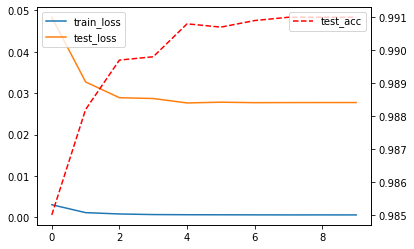

In [9]:
# https://matplotlib.org/gallery/api/two_scales.html

train_loss = np.array(train_loss)
test_loss = np.array(test_loss)
test_acc = np.array(test_acc)

fig, ax1 = plt.subplots()
ax1.plot(np.stack([train_loss, test_loss]).T);

ax2 = ax1.twinx()
ax2.plot(test_acc, 'r--', label='test_acc');


ax1.legend(labels=['train_loss', 'test_loss'], loc='upper left')
ax2.legend(loc='upper right');

# plt.savefig('../dip_outs/conv_MNIST_torch_training.png', dpi=300)

&nbsp;

## Let's get the output of the model for all the test data.
Since the test_loader is also shuffled, we're going to want to keep track of the target too, to know what the answer should have been. In fact, let's just keep all of it. 

In the below cell we loop over all the test data, push it through the model and store the resulting classifier outputs. The expression `model(data.to(device))` sends the data to the GPU (where the model resides) and applies the model to it. The sequence that happens after, `.cpu().detach().numpy()`, takes the resulting outputs and brings it back to the cpu memory space in the form of a numpy array.

A [notes on pretty-printing arrays](https://stackoverflow.com/questions/2891790/how-to-pretty-print-a-numpy-array-without-scientific-notation-and-with-given-pre).

In [10]:
model.eval() # make sure the model weights don't change.
outputs = np.concatenate([model(data.to(device)).cpu().detach().numpy() 
              for data, target in test_loader], axis=0)

In [11]:
outputs[0]

array([-2.1769821e+01, -2.3476885e+01, -1.9529434e+01, -1.5465795e+01,
       -2.7317522e+01, -2.7012657e+01, -3.4243114e+01, -2.3841855e-07,
       -2.4861803e+01, -1.7080139e+01], dtype=float32)

In [12]:
# The last function in the model is a log_softmax, which is a log after softmax.
# Softmax makes the outputs all in [0,1] and sum to 1, but then there is a log 
# after that. So we undo that to see the [0,1] numbers, which can be thought of 
# as probabilities.
with np.printoptions(precision=4, suppress=True):
    print(np.exp(outputs[0]))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## Just for fun, let's see some of the mistakes...

In [13]:
correct_labels = np.concatenate([target for data, target in test_loader], axis=0)

In [14]:
correct_labels.shape

(10000,)

In [15]:
proposed_labels = np.argmax(outputs, axis=-1)

In [16]:
proposed_labels.shape

(10000,)

In [17]:
sum(proposed_labels == correct_labels)

9910

In [18]:
wrong_guesses = np.where(proposed_labels != correct_labels)[0]

In [19]:
wrong_guesses

array([ 259,  320,  321,  340,  445,  582,  684,  717,  740,  938,  947,
       1014, 1039, 1112, 1226, 1232, 1260, 1319, 1393, 1414, 1522, 1527,
       1530, 1549, 1621, 1681, 1709, 1790, 1878, 1901, 2035, 2043, 2109,
       2118, 2129, 2130, 2135, 2293, 2387, 2414, 2454, 2462, 2488, 2597,
       2654, 2896, 2921, 2939, 3030, 3073, 3289, 3422, 3503, 3520, 3727,
       3767, 3778, 3808, 3853, 3906, 3941, 4065, 4176, 4256, 4497, 4507,
       4536, 4740, 4761, 4807, 4860, 5331, 5937, 5955, 6555, 6597, 6625,
       6651, 8094, 8325, 8527, 9009, 9015, 9019, 9638, 9664, 9692, 9729,
       9770, 9839])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


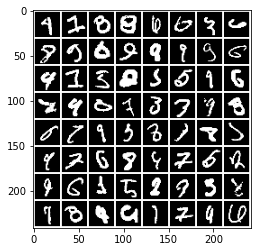

In [20]:
from torchvision.utils import make_grid

which_wrong = np.random.choice(wrong_guesses, 64, replace=False)
samples = torch.stack([mnist_testset[r][0]
                       for r in which_wrong])
plt.imshow(make_grid(samples, nrow=8, pad_value=1.0).permute(1,2,0))

In [21]:
print('Predicted: ' + ' '.join(['%d' % x for x in proposed_labels[which_wrong]]))
print('Actual:    ' + ' '.join(['%d' % x for x in correct_labels[which_wrong]]))

Predicted: 9 2 0 9 0 0 7 4 9 5 0 8 9 8 5 5 9 2 3 0 3 0 1 5 7 9 5 2 2 7 7 8 8 8 1 5 3 2 7 3 8 7 5 9 4 2 6 4 4 8 5 8 8 7 3 2 9 0 9 0 1 2 4 0
Actual:    4 1 8 8 6 6 3 6 8 9 6 9 8 9 9 6 4 1 5 2 5 5 9 6 2 4 0 7 3 3 9 3 0 7 9 3 8 1 8 5 9 2 6 8 9 7 5 2 9 6 1 5 2 9 5 8 7 8 4 9 7 7 9 6


In [22]:
print('\n'.join([str((x,y)) for x,y in zip(proposed_labels[which_wrong], correct_labels[which_wrong])]))

(9, 4)
(2, 1)
(0, 8)
(9, 8)
(0, 6)
(0, 6)
(7, 3)
(4, 6)
(9, 8)
(5, 9)
(0, 6)
(8, 9)
(9, 8)
(8, 9)
(5, 9)
(5, 6)
(9, 4)
(2, 1)
(3, 5)
(0, 2)
(3, 5)
(0, 5)
(1, 9)
(5, 6)
(7, 2)
(9, 4)
(5, 0)
(2, 7)
(2, 3)
(7, 3)
(7, 9)
(8, 3)
(8, 0)
(8, 7)
(1, 9)
(5, 3)
(3, 8)
(2, 1)
(7, 8)
(3, 5)
(8, 9)
(7, 2)
(5, 6)
(9, 8)
(4, 9)
(2, 7)
(6, 5)
(4, 2)
(4, 9)
(8, 6)
(5, 1)
(8, 5)
(8, 2)
(7, 9)
(3, 5)
(2, 8)
(9, 7)
(0, 8)
(9, 4)
(0, 9)
(1, 7)
(2, 7)
(4, 9)
(0, 6)


In [23]:
# !jupyter nbconvert --to script 'conv_MNIST_torch.ipynb'